In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sncosmo
import emcee
from multiprocessing import Pool
import glob
import quadpy
from matplotlib.offsetbox import AnchoredText
import getdist
from getdist import plots, MCSamples
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid", {'axes.grid':'False','xtick.bottom': True,'ytick.left': True})

params = {"text.usetex" : True,'font.size': 20, 'font.family':'serif', 'font.serif':'Computer Modern'}
plt.rcParams.update(params)

gk = quadpy.c1.gauss_kronrod(40)

In [2]:
pantheon_ori_fits=pd.read_csv("pantheon_original_fit.txt",sep="\s+")

## Carregando dados EXP

In [3]:
glob.glob("./lc_fit_results*.txt")

['./lc_fit_results_EXP_PCA_LOWZ_Pantheon.txt',
 './lc_fit_results_EXP_PCA_PS1_Pantheon.txt',
 './lc_fit_results_EXP_PCA_SDSS_Pantheon.txt',
 './lc_fit_results_EXP_PCA_HST_Pantheon.txt',
 './lc_fit_results_EXP_PCA_SNLS_Pantheon.txt']

In [4]:
SDSS_fits=pd.read_csv("./lc_fit_results_EXP_PCA_SDSS_Pantheon.txt",sep="\s+")
SNLS_fits=pd.read_csv("./lc_fit_results_EXP_PCA_SNLS_Pantheon.txt",sep="\s+")
PS1_fits=pd.read_csv("./lc_fit_results_EXP_PCA_PS1_Pantheon.txt",sep="\s+")
HST_fits=pd.read_csv("./lc_fit_results_EXP_PCA_HST_Pantheon.txt",sep="\s+")
LOWZ_fits=pd.read_csv("./lc_fit_results_EXP_PCA_LOWZ_Pantheon.txt",sep="\s+")

In [5]:
df_exp_bf_cuts=pd.concat([PS1_fits,SNLS_fits,SDSS_fits,LOWZ_fits,HST_fits])

In [6]:
df_exp=df_exp_bf_cuts[(df_exp_bf_cuts["X1"]>-3.5) & (df_exp_bf_cuts["X1"]<3.) &
                      (df_exp_bf_cuts["X2/C"]>-3.) & (df_exp_bf_cuts["X2/C"]<3.) &
                      (df_exp_bf_cuts["X1ERR"]>0.) & (df_exp_bf_cuts["X1ERR"]<10.) &
                      (df_exp_bf_cuts["X2/CERR"]>0.) & (df_exp_bf_cuts["X2/CERR"]<10.) &
                      (df_exp_bf_cuts["CHISQ/NDOF"]<=15.)].reset_index(drop=True)

## Carregando dados SALT2

In [7]:
glob.glob("./fits_SALT2/lc_fit_results*.txt")

['./fits_SALT2/lc_fit_results_SALT2_LOWZ_Pantheon.txt',
 './fits_SALT2/lc_fit_results_SALT2_HST_Pantheon.txt',
 './fits_SALT2/lc_fit_results_SALT2_SNLS_Pantheon.txt',
 './fits_SALT2/lc_fit_results_SALT2_SDSS_Pantheon.txt',
 './fits_SALT2/lc_fit_results_SALT2_PS1_Pantheon.txt']

In [8]:
SDSS_fits_SALT2=pd.read_csv("./fits_SALT2/lc_fit_results_SALT2_SDSS_Pantheon.txt",sep="\s+")
SNLS_fits_SALT2=pd.read_csv("./fits_SALT2/lc_fit_results_SALT2_SNLS_Pantheon.txt",sep="\s+")
PS1_fits_SALT2=pd.read_csv("./fits_SALT2/lc_fit_results_SALT2_PS1_Pantheon.txt",sep="\s+")
HST_fits_SALT2=pd.read_csv("./fits_SALT2/lc_fit_results_SALT2_HST_Pantheon.txt",sep="\s+")
LOWZ_fits_SALT2=pd.read_csv("./fits_SALT2/lc_fit_results_SALT2_LOWZ_Pantheon.txt",sep="\s+")

In [9]:
df_salt2_bf_cuts=pd.concat([PS1_fits_SALT2,SNLS_fits_SALT2,SDSS_fits_SALT2,LOWZ_fits_SALT2,HST_fits_SALT2])

In [10]:
df_salt2=df_salt2_bf_cuts[(abs(df_salt2_bf_cuts["X1"])<=3.) & (abs(df_salt2_bf_cuts["X2/C"])<=0.3)].reset_index(drop=True)

## MCMC

#### MCMC EXP

In [11]:
class cosmo:
    def __init__(self, data):
        self.data = data
        
    def dL(self,Ok, integral):
        if(Ok[0]>0.):
            return 1./np.sqrt(Ok[0])*np.sinh(np.sqrt(Ok[0])*np.array(integral))
        elif(Ok[0]==0.):
            return integral
        elif(Ok[0]<0.):
            return 1./np.sqrt(-Ok[0])*np.sin(np.sqrt(-Ok[0])*np.array(integral))
    
    def log_likelihood_exp(self,theta):
        alpha, beta, sigma=theta
        Om=0.3404
        Ol=0.4831
        M=15.8689
        deltaM=-0.0296

        Ok=1.-Om-Ol
        h_inv=lambda x: 1./np.sqrt(Om*(1+x)**3.+Ol+(1.-Om-Ol)*(1+x)**2.)
        integral=gk.integrate(h_inv,[np.array([0.]*len(self.data["z"])),np.array(self.data["z"])])

        model=5*np.log10((1+self.data["z"])*self.dL(np.array([Ok]*len(integral)),integral))+M
        mu=self.data["mB"]-2.5*np.log10(1-self.data["x1"]*alpha+self.data["x2"]*beta)-deltaM*self.data["is_log_mass_g_10"]
    
        sigmaz=0.0012*(5/np.log(10.))*(1.+self.data["z"])/(self.data["z"]*(1.+self.data["z"]/2.))
        
        fator=-2.5/(np.log(10.)*(1-self.data["x1"]*alpha+self.data["x2"]*beta))
        
        cov=-2.*fator*alpha*self.data["cov_mB_x1"]+2.*fator*beta*self.data["cov_mB_x2"]-2.*fator**2*alpha*beta*self.data["cov_x1_x2"]
        sigma2=sigma**2+sigmaz**2.+self.data["mBerr"]**2+fator**2*alpha**2.*self.data["x1err"]**2+fator**2*beta**2.*self.data["x2err"]**2.+cov
        
        lnlike=-0.5*np.sum((mu-model)**2./sigma2 + np.log(2*np.pi*sigma2))
        
        if not np.isfinite(lnlike):
            return -np.inf
        return lnlike
    
    def log_prior_exp(self, theta):
        alpha, beta, sigma=theta     
        if not (-1. < alpha < 1. and -1.< beta < 1. and 0.<sigma <0.5):
            return -np.inf
        return 0. 
        
    def log_probability_exp(self,theta):
        lp = self.log_prior_exp(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.log_likelihood_exp(theta)


In [12]:
exp_data=df_exp[df_exp["SNNAME"].isin(df_salt2["SNNAME"])].reset_index(drop=True)

In [13]:
exp_data["SNNAME"]=exp_data["SNNAME"].astype("str")

In [14]:
hostmass={}

In [15]:
i=0
j=0
for sn in pantheon_ori_fits["CID"]:
    if sn in exp_data["SNNAME"].values:
        i+=1
        hostmass[sn]=pantheon_ori_fits[pantheon_ori_fits["CID"]==sn]["HOST_LOGMASS"].values[0]
        continue
    else:
        try:
            sn_int=int(sn)
            if str(sn_int) in exp_data["SNNAME"].values:
                i+=1
                hostmass[str(sn_int)]=pantheon_ori_fits[pantheon_ori_fits["CID"]==sn]["HOST_LOGMASS"].values[0]
                continue
            else:
                j+=1
                continue
        except:
            j+=1
            continue

print(f"{j} não estão na lista")
print(f"{i} estão na lista")

364 não estão na lista
684 estão na lista


In [16]:
reduced_exp_data=exp_data[exp_data["SNNAME"].isin(hostmass.keys())].reset_index(drop=True)

In [17]:
col_hostmass=[]
is_log_mass_g_10=[]
for sn in reduced_exp_data["SNNAME"]:
    col_hostmass.append(hostmass[sn])
    if hostmass[sn]<10.:
        is_log_mass_g_10.append(0.)
    else:
        is_log_mass_g_10.append(1.)

In [18]:
col_hostmass=pd.DataFrame(col_hostmass)
col_hostmass.columns=["LOG_HOST_GAL_MASS"]
is_log_mass_g_10=pd.DataFrame(is_log_mass_g_10)
is_log_mass_g_10.columns=["is_log_mass_g_10"]

In [19]:
final_exp_data=pd.concat((reduced_exp_data,col_hostmass,is_log_mass_g_10),axis=1)

In [20]:
data_exp=final_exp_data[["SNNAME","LOG_HOST_GAL_MASS","Z","ZERR","mB","mBERR","X1","X1ERR","X2/C","X2/CERR","COV_mB_X1","COV_mB_X2/C","COV_X1_X2/C","is_log_mass_g_10"]]

In [21]:
data_exp.columns=["sn","log_hm","z","zerr","mB","mBerr","x1","x1err","x2","x2err","cov_mB_x1","cov_mB_x2","cov_x1_x2","is_log_mass_g_10"]

In [22]:
len(data_exp)

684

In [23]:
data_z_sorted=data_exp.sort_values("z").reset_index(drop=True)

In [24]:
intervalo1=data_z_sorted[data_z_sorted["z"]<0.025] # 45 sn
intervalo2=data_z_sorted[(data_z_sorted["z"]>=0.025) & (data_z_sorted["z"]<0.04)] # 44 sn
intervalo3=data_z_sorted[(data_z_sorted["z"]>=0.04) & (data_z_sorted["z"]<0.08)] # 37 sn
intervalo4=data_z_sorted[(data_z_sorted["z"]>=0.08) & (data_z_sorted["z"]<0.12)] # 37 sn
intervalo5=data_z_sorted[(data_z_sorted["z"]>=0.12) & (data_z_sorted["z"]<0.14)] # 36 sn
intervalo6=data_z_sorted[(data_z_sorted["z"]>=0.14) & (data_z_sorted["z"]<0.17)] # 42 sn
intervalo7=data_z_sorted[(data_z_sorted["z"]>=0.17) & (data_z_sorted["z"]<0.19)] # 44 sn
intervalo8=data_z_sorted[(data_z_sorted["z"]>=0.19) & (data_z_sorted["z"]<0.215)] # 39 sn
intervalo9=data_z_sorted[(data_z_sorted["z"]>=0.215) & (data_z_sorted["z"]<0.24)] # 32 sn
intervalo10=data_z_sorted[(data_z_sorted["z"]>=0.24) & (data_z_sorted["z"]<0.26)] # 37 sn
intervalo11=data_z_sorted[(data_z_sorted["z"]>=0.26) & (data_z_sorted["z"]<0.29)] # 38 sn
intervalo12=data_z_sorted[(data_z_sorted["z"]>=0.29) & (data_z_sorted["z"]<0.32)] # 36 sn
intervalo13=data_z_sorted[(data_z_sorted["z"]>=0.32) & (data_z_sorted["z"]<0.37)] # 37 sn
intervalo14=data_z_sorted[(data_z_sorted["z"]>=0.37) & (data_z_sorted["z"]<0.44)] # 39 sn
intervalo15=data_z_sorted[(data_z_sorted["z"]>=0.44) & (data_z_sorted["z"]<0.55)] # 33 sn
intervalo16=data_z_sorted[(data_z_sorted["z"]>=0.55) & (data_z_sorted["z"]<0.66)] # 33 sn
intervalo17=data_z_sorted[(data_z_sorted["z"]>=0.66) & (data_z_sorted["z"]<0.8)] # 31 sn
intervalo18=data_z_sorted[(data_z_sorted["z"]>=0.8) & (data_z_sorted["z"]<1.2)] # 35 sn

In [25]:
len(data_exp[data_exp["z"]>=1.2]) # 9 sn are not considered

9

In [26]:
for dat in [intervalo1,intervalo2,intervalo3,intervalo4,intervalo5,intervalo6,intervalo7,intervalo8,intervalo9,intervalo10,intervalo11,intervalo12,intervalo13,intervalo14,intervalo15,intervalo16,intervalo17,intervalo18]:
    print(np.mean(dat["z"]))

0.01854853027112422
0.03200468457204545
0.05618458689567839
0.1029105945945946
0.13016802777777775
0.15349238095238096
0.17959975
0.20398858974358974
0.22626628124999998
0.2485844054054054
0.272352
0.30309025
0.34382975675675664
0.40232243589743594
0.49377575757575765
0.5926181818181818
0.7409387096774193
0.8819142857142858


5.849413481289726


100%|███████████████████████████████████████| 6000/6000 [07:12<00:00, 13.87it/s]


38.23551081978814
0.6339972222222222


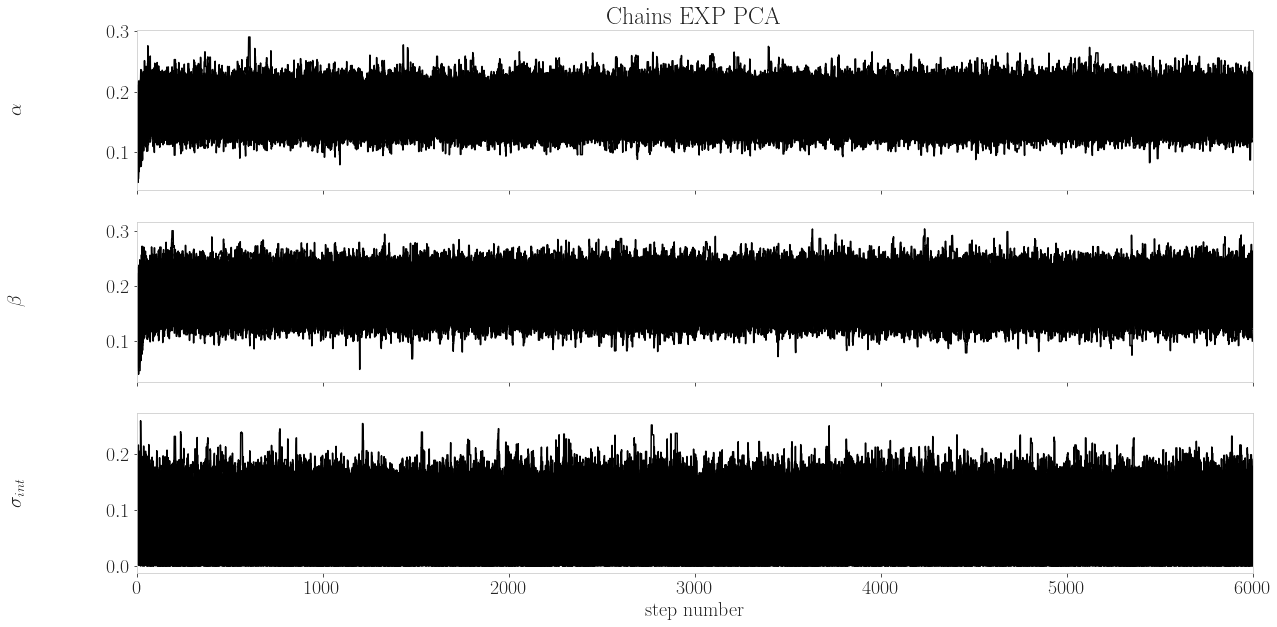

1.4777927891868328


 88%|██████████████████████████████████▎    | 5273/6000 [07:01<00:57, 12.66it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|███████████████████████████████████████| 6000/6000 [07:59<00:00, 12.52it/s]


36.668141737487716
0.64531


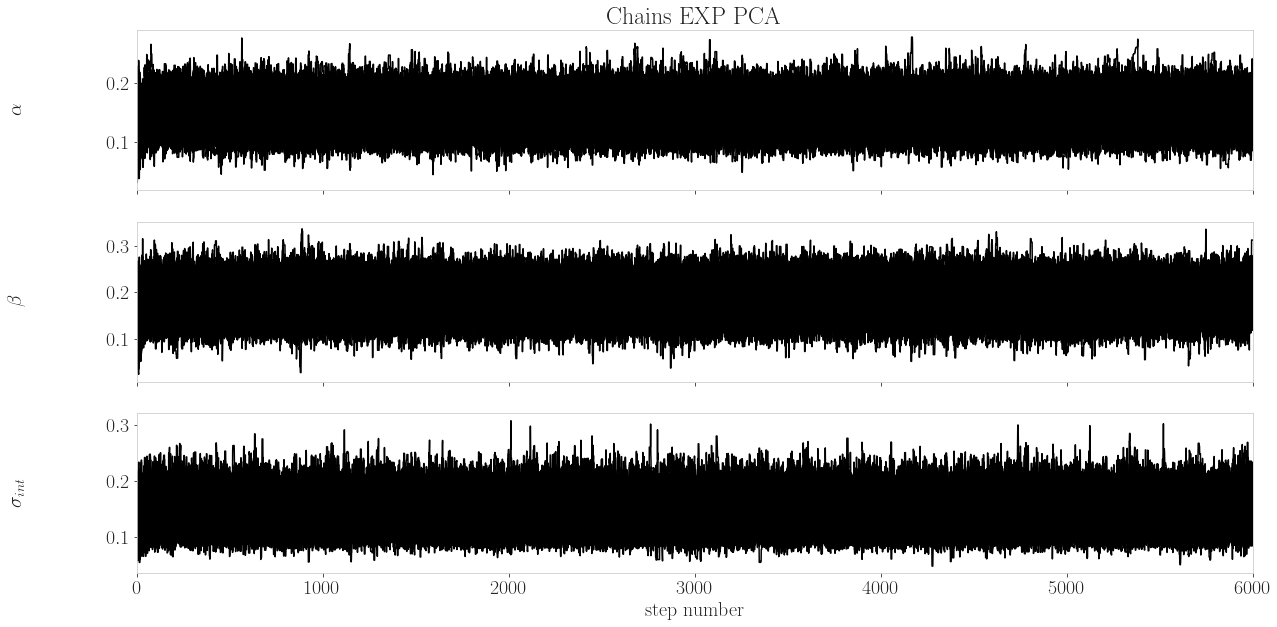

-6.120334916525646


  1%|▎                                        | 49/6000 [00:03<07:53, 12.57it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
  2%|▋                                        | 93/6000 [00:07<07:53, 12.48it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
  2%|▊                                       | 115/6000 [00:09<07:51, 12.47it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
  3%|█▏                                      | 183/6000 [00:14<07:41, 12.61it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: Runt

37.03718060559033
0.6449538888888888


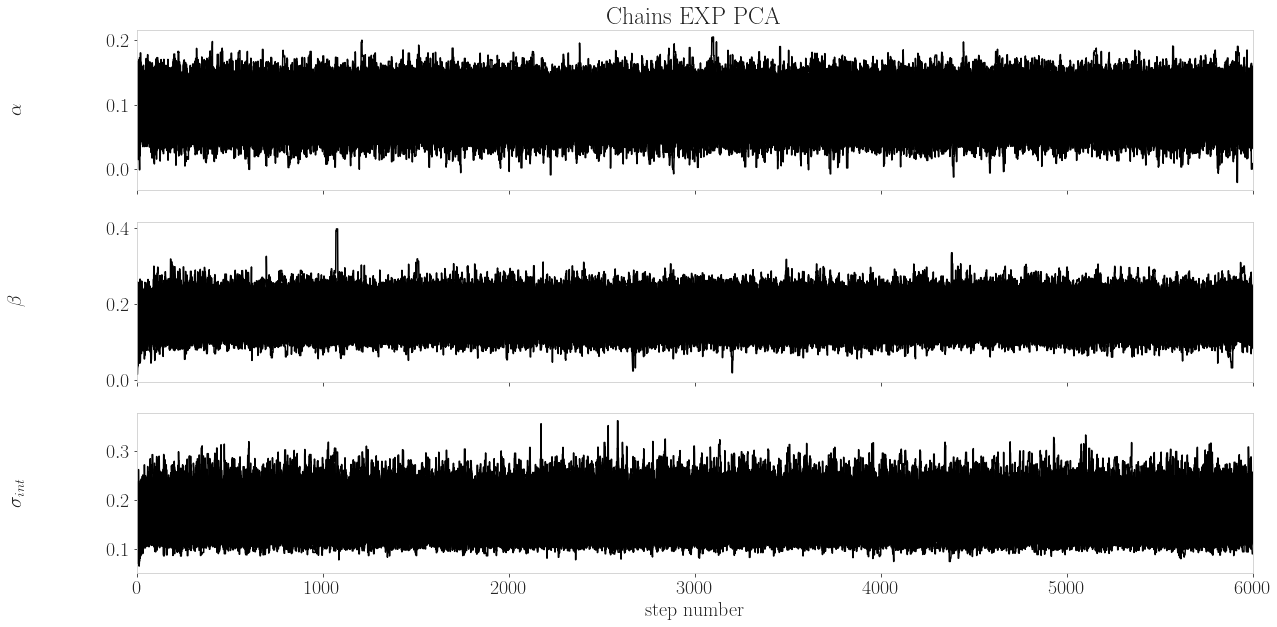

12.360860079934202


100%|███████████████████████████████████████| 6000/6000 [08:07<00:00, 12.30it/s]


37.14603619195102
0.6435111111111111


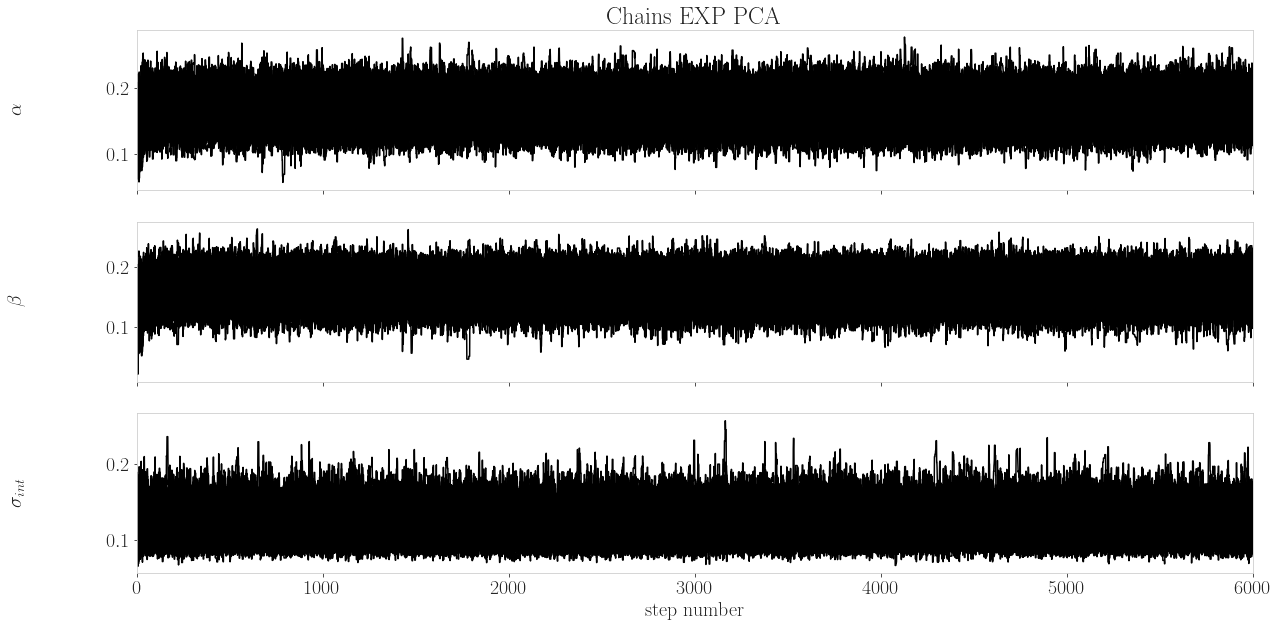

-0.5655820691860589


100%|███████████████████████████████████████| 6000/6000 [08:10<00:00, 12.23it/s]


36.928107723788564
0.6433616666666666


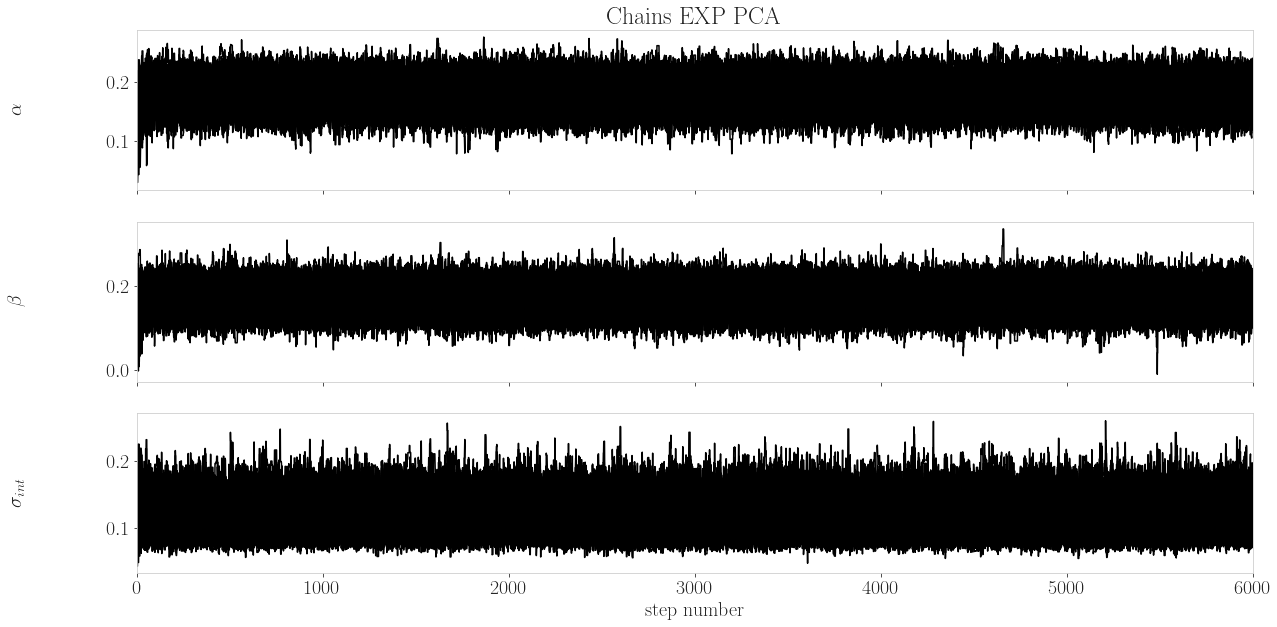

-7.2739125860526475


100%|███████████████████████████████████████| 6000/6000 [08:12<00:00, 12.17it/s]


36.77558914166414
0.644653888888889


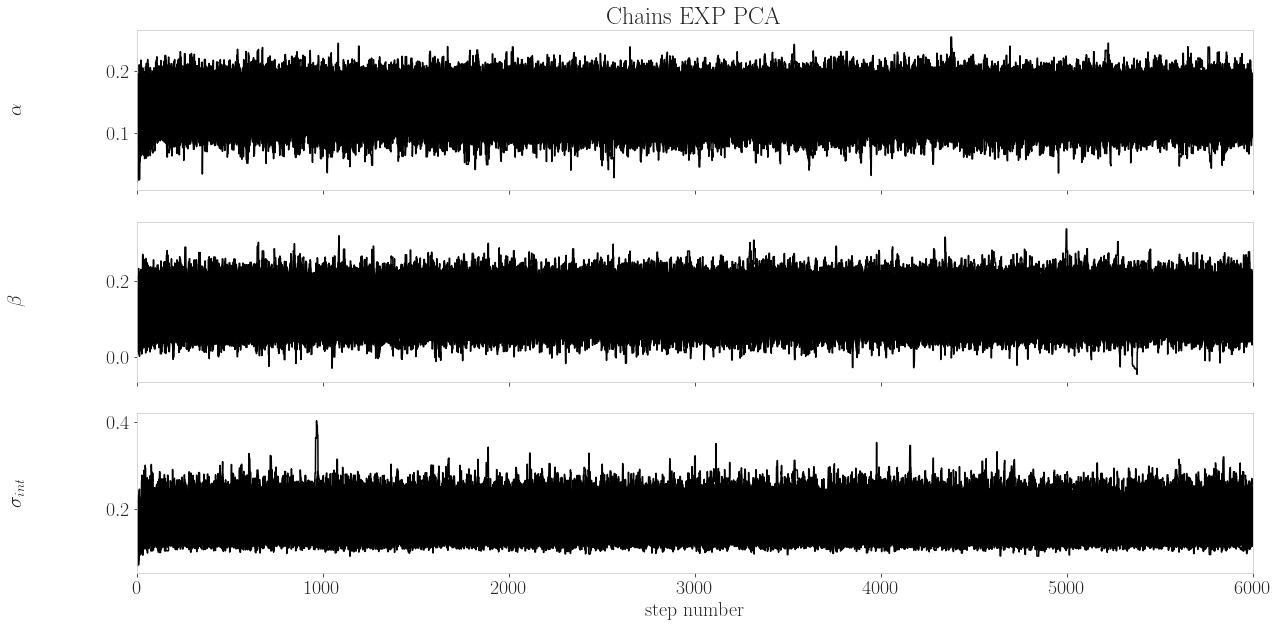

4.60089071222416


100%|███████████████████████████████████████| 6000/6000 [08:13<00:00, 12.15it/s]


36.6402487201753
0.6467516666666665


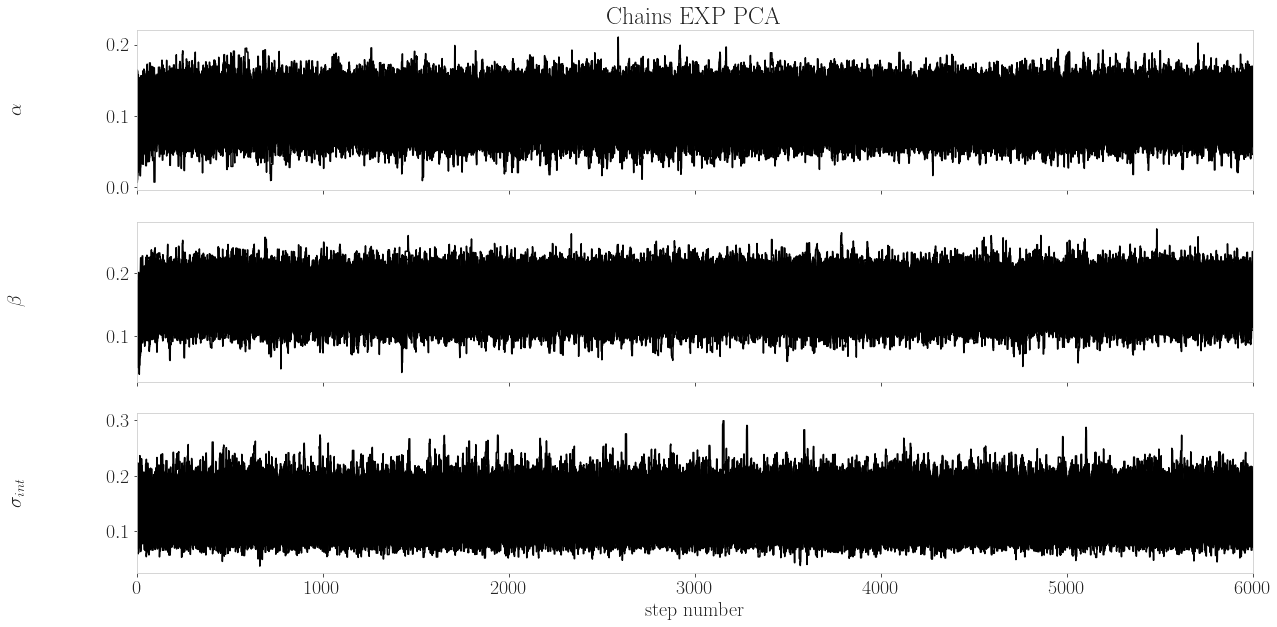

22.277040617033524


100%|███████████████████████████████████████| 6000/6000 [08:11<00:00, 12.20it/s]


35.711490970348734
0.6484255555555556


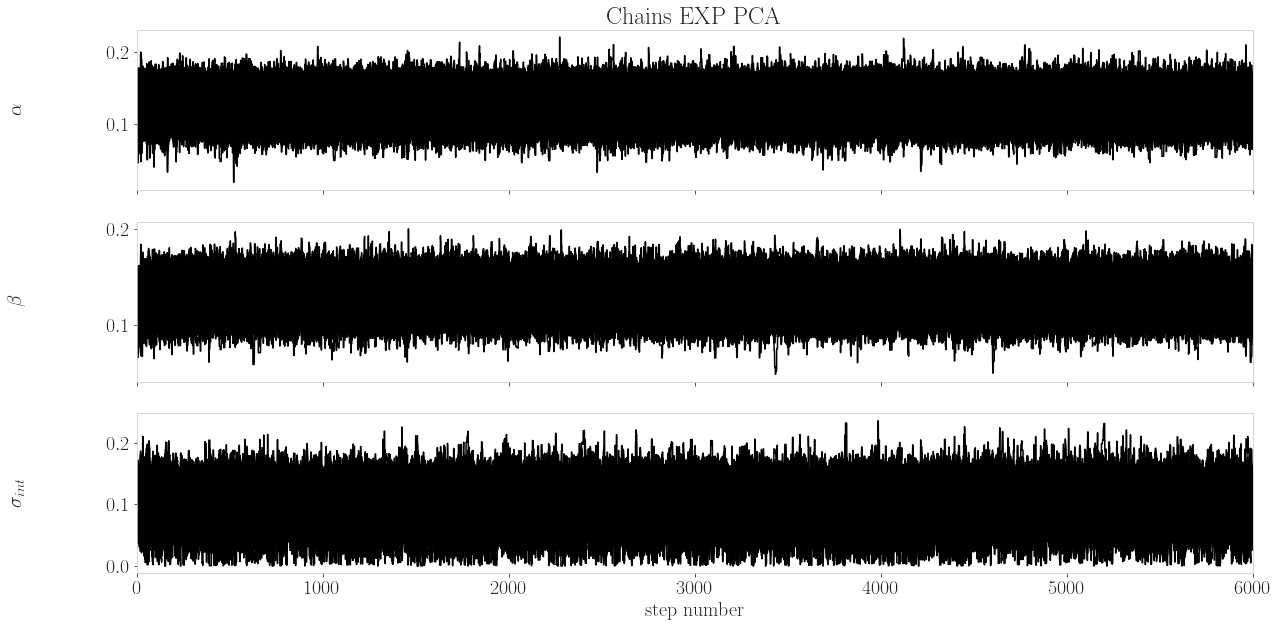

-5.182391863427605


  3%|█▎                                      | 204/6000 [00:16<07:54, 12.21it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
  3%|█▎                                      | 206/6000 [00:16<07:54, 12.21it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
  5%|█▉                                      | 288/6000 [00:23<07:44, 12.31it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)

36.65752873413787
0.6459322222222222


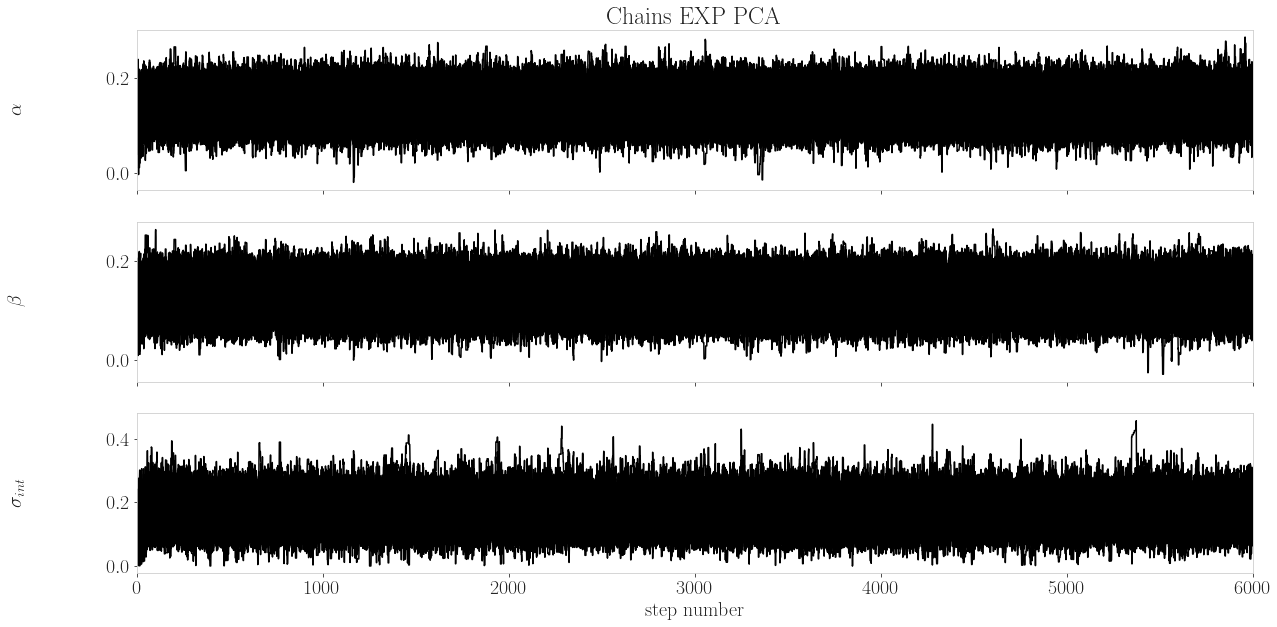

4.909043221819556


100%|███████████████████████████████████████| 6000/6000 [08:14<00:00, 12.13it/s]


36.138782337844795
0.6469666666666668


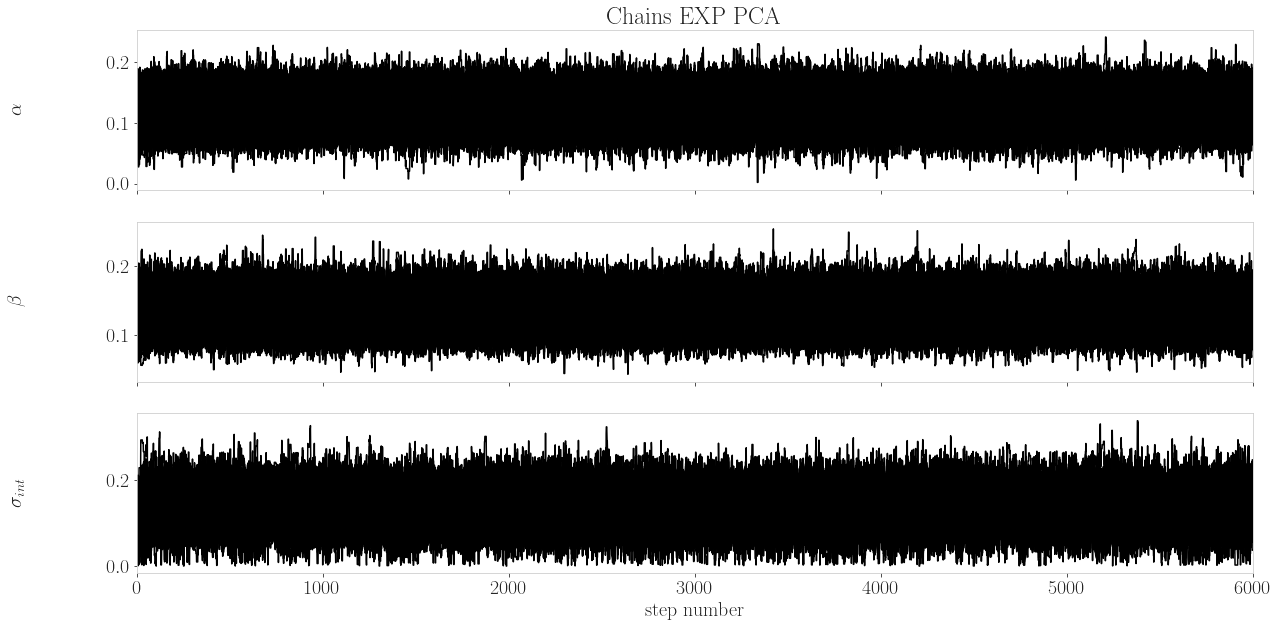

2.9848579291821116


100%|███████████████████████████████████████| 6000/6000 [08:07<00:00, 12.30it/s]


36.502090642843044
0.6469672222222221


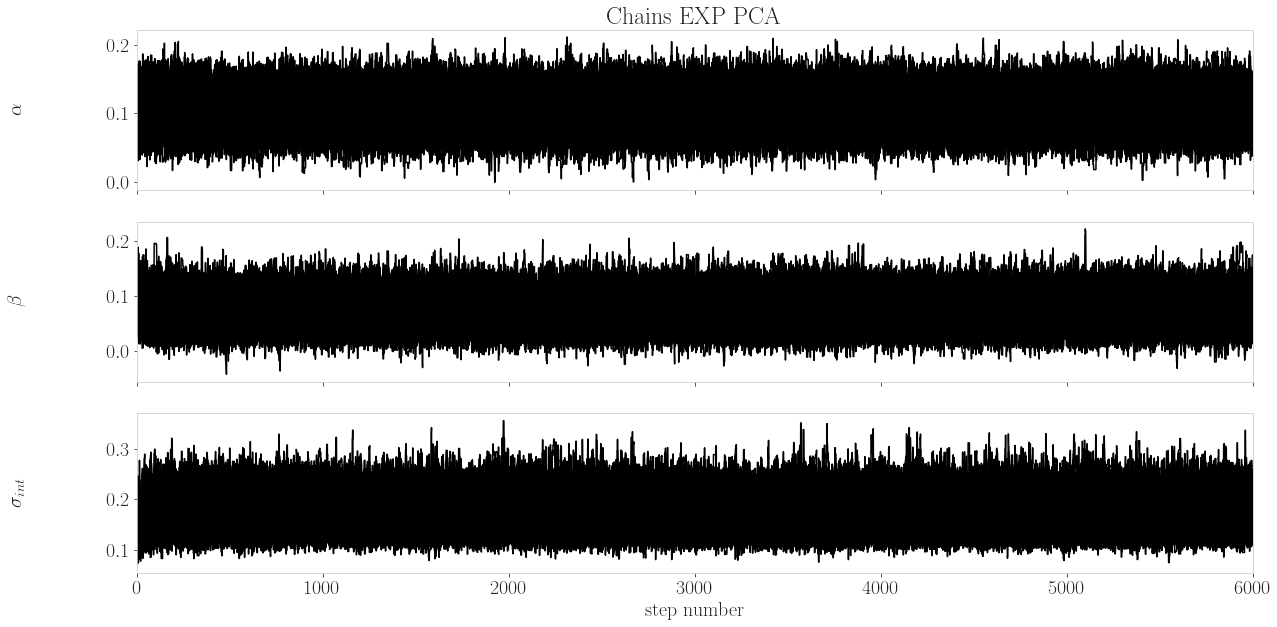

-0.7767887661856069


100%|███████████████████████████████████████| 6000/6000 [08:06<00:00, 12.32it/s]


36.29032689996155
0.647335


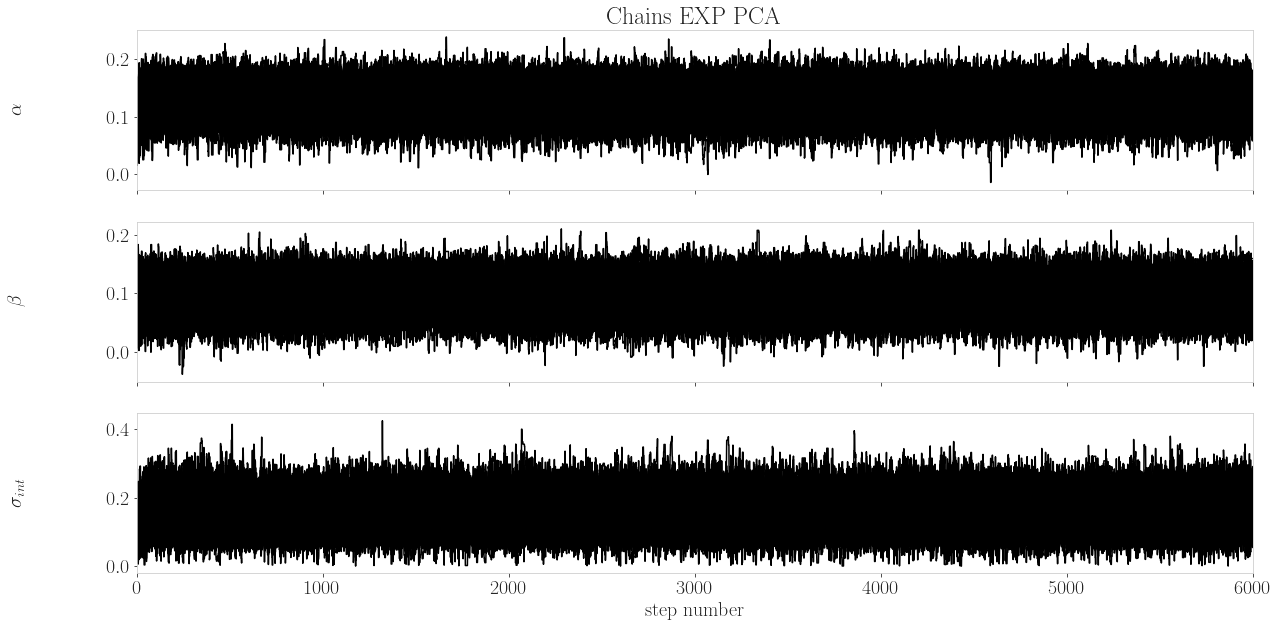

9.304052960474564


100%|███████████████████████████████████████| 6000/6000 [08:11<00:00, 12.22it/s]


36.917465622385116
0.6448550000000001


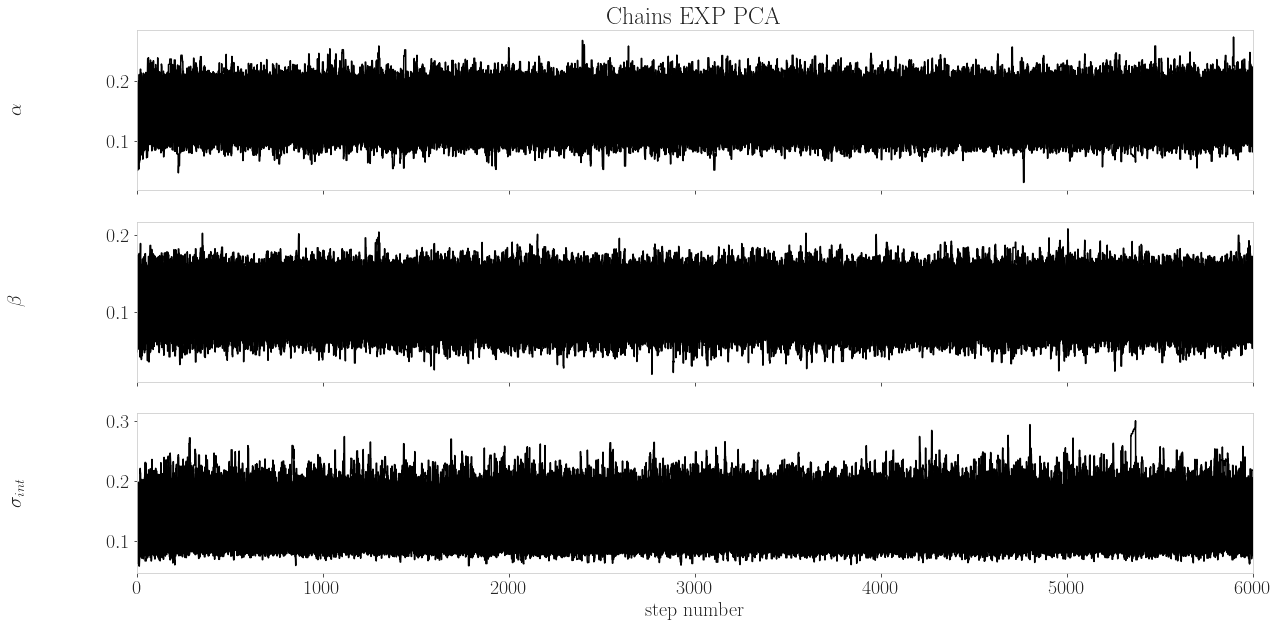

1.949273405839167


100%|███████████████████████████████████████| 6000/6000 [08:10<00:00, 12.24it/s]


37.058127756497946
0.6427483333333334


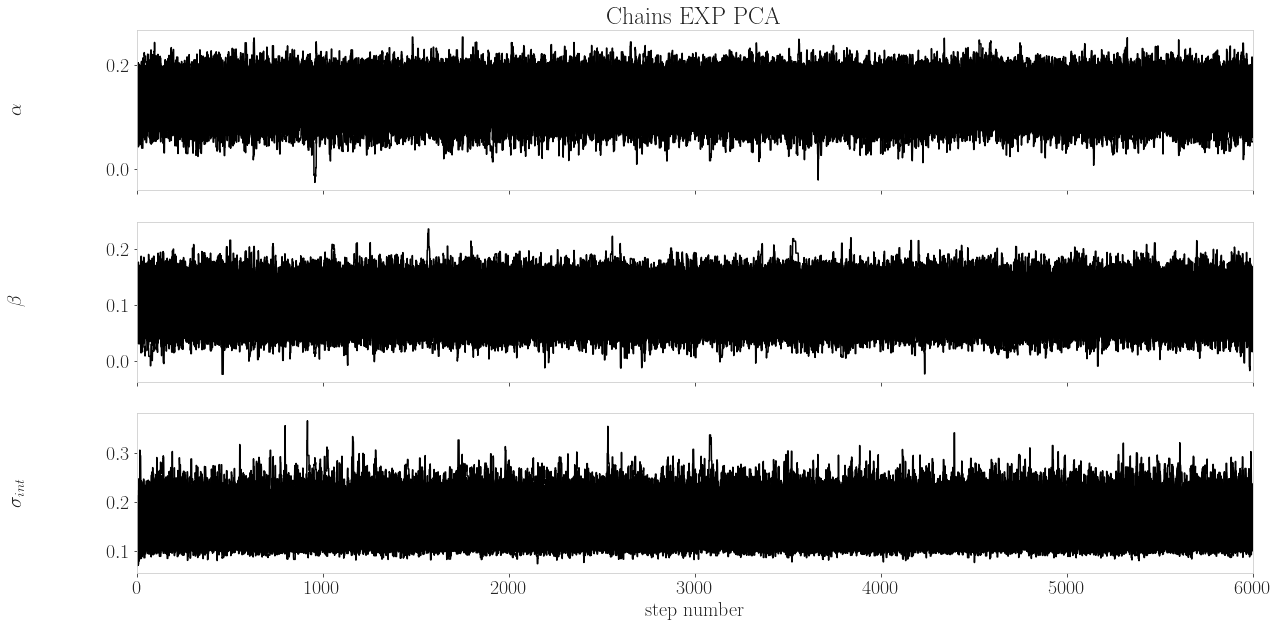

-11.226189807534917


  8%|███                                     | 460/6000 [00:37<07:36, 12.13it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
  9%|███▌                                    | 542/6000 [00:44<07:27, 12.18it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
 10%|███▉                                    | 594/6000 [00:48<07:26, 12.10it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
 44%|█████████████████                      | 2624/6000 [03:33<04:33, 12.34it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: Runt

37.480650195748254
0.6424416666666667


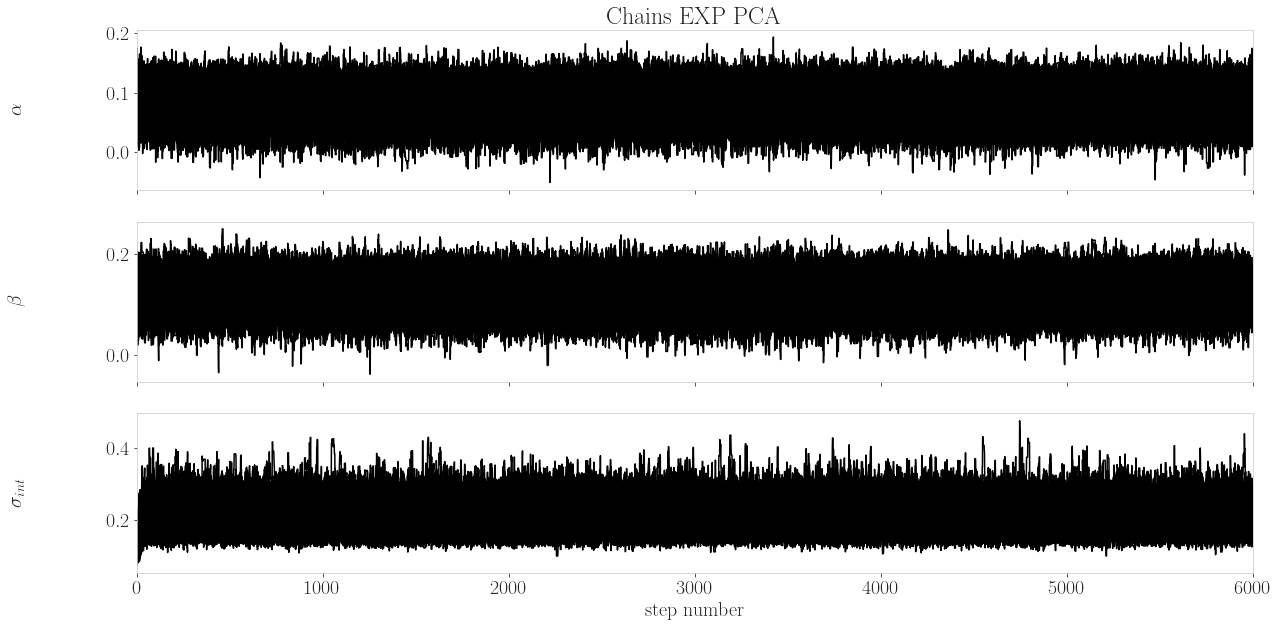

7.557154898597355


100%|███████████████████████████████████████| 6000/6000 [08:10<00:00, 12.22it/s]


36.50631275952967
0.6446033333333332


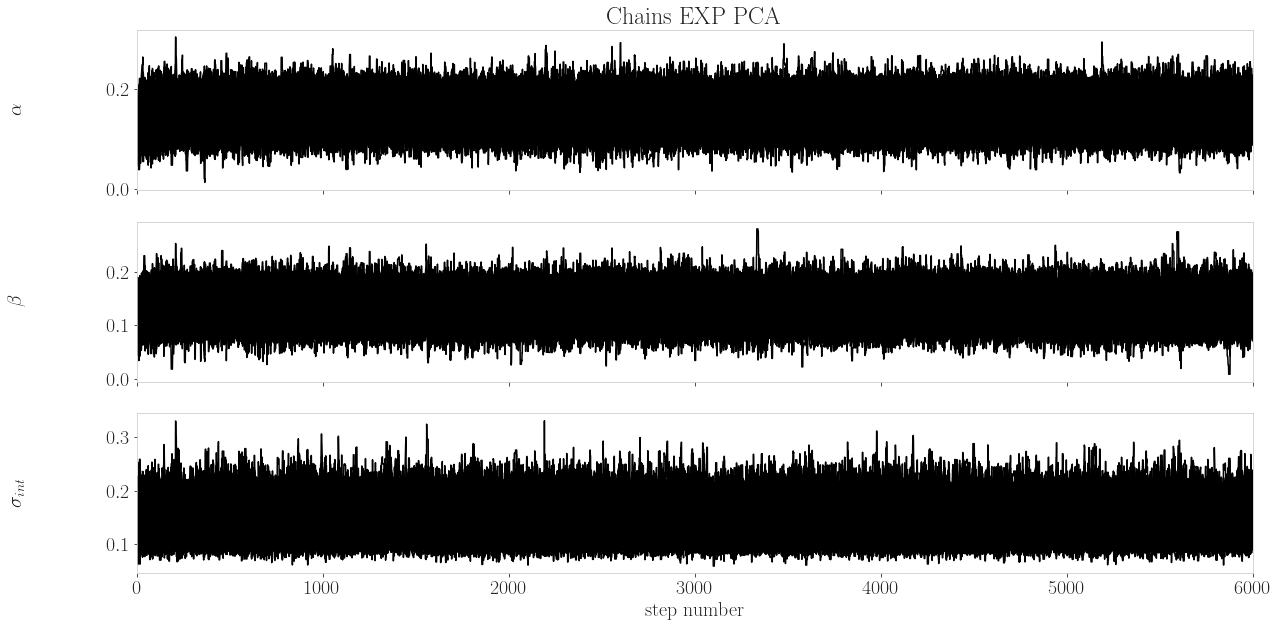

3.0942924651436092


100%|███████████████████████████████████████| 6000/6000 [08:07<00:00, 12.30it/s]


35.960703427022
0.6467233333333333


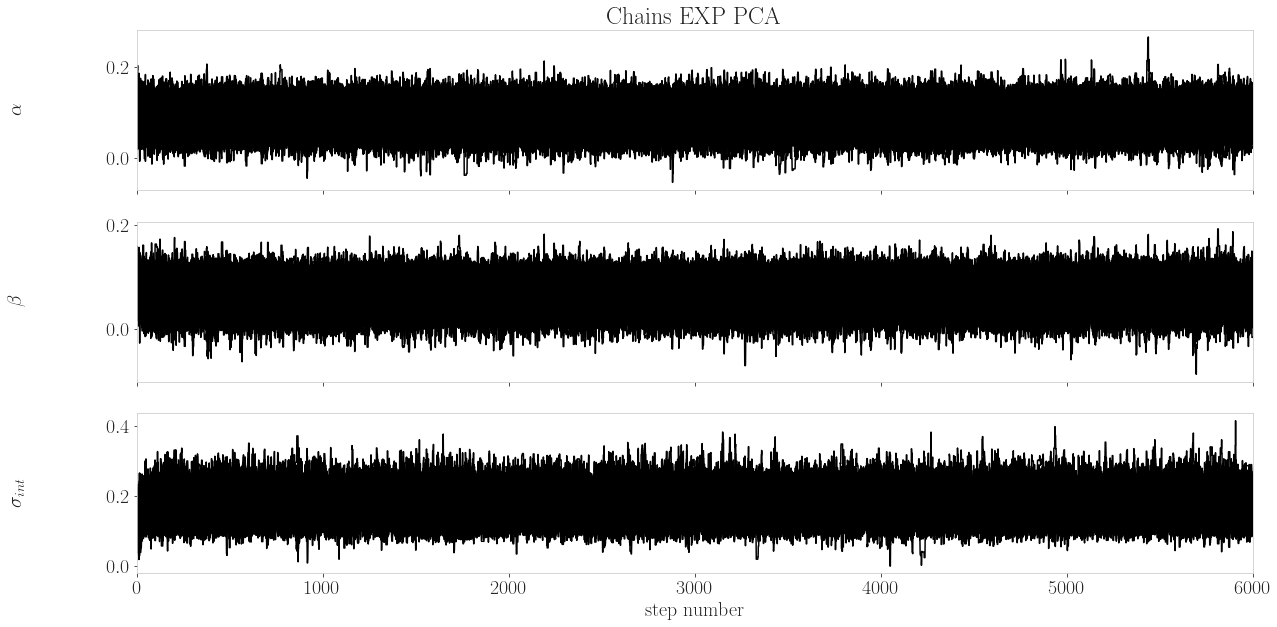

0.8549339625307815


 25%|█████████▊                             | 1514/6000 [02:03<06:04, 12.32it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|███████████████████████████████████████| 6000/6000 [08:11<00:00, 12.22it/s]


35.9062320674718
0.6455266666666666


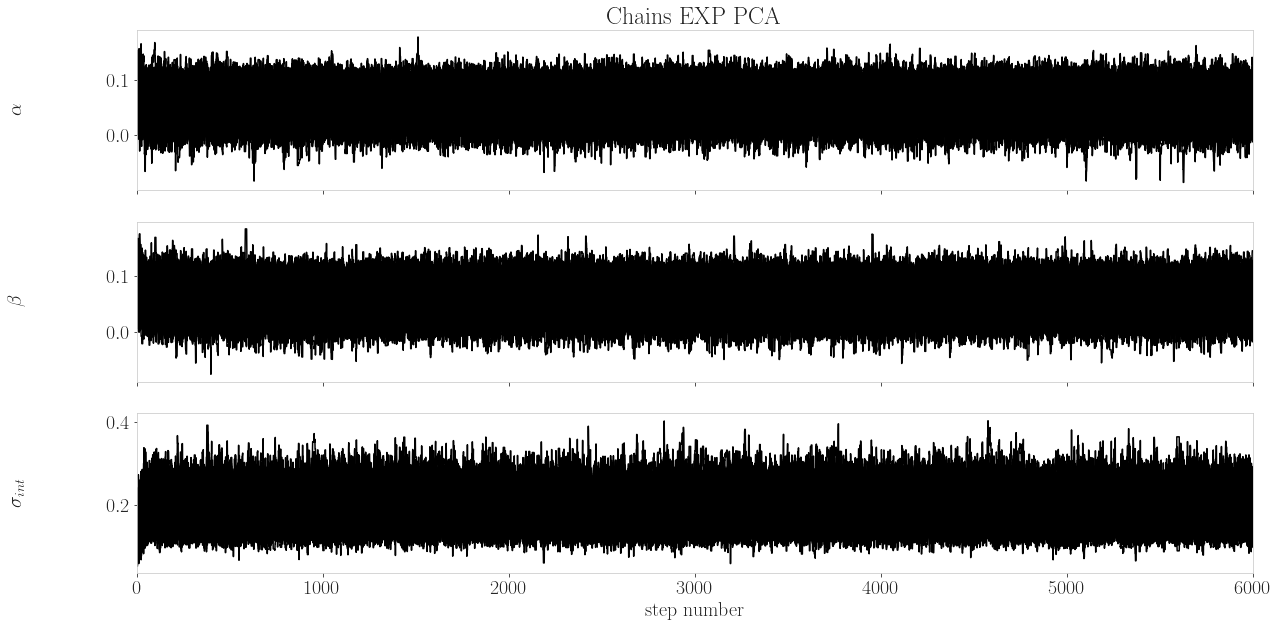

In [27]:
for j,dat in enumerate([intervalo1,intervalo2,intervalo3,intervalo4,intervalo5,intervalo6,intervalo7,intervalo8,intervalo9,intervalo10,intervalo11,intervalo12,intervalo13,intervalo14,intervalo15,intervalo16,intervalo17,intervalo18]):
    cosmo_exp=cosmo(dat)
    print(cosmo_exp.log_probability_exp([0.1,0.1,0.1]))
    pos = np.array([0.1,0.1,0.1])+0.01 *np.random.randn(300, 3)
    nwalkers, ndim = pos.shape
    
    with Pool() as pool:
        sampler_exp = emcee.EnsembleSampler(nwalkers, ndim, cosmo_exp.log_probability_exp, pool=pool)
        sampler_exp.run_mcmc(pos, 6000, progress=True)
    
    print(np.mean(sampler_exp.get_autocorr_time()))
    
    print(np.mean(sampler_exp.acceptance_fraction))
    
    fig, axes = plt.subplots(ndim, figsize=(20, 10), sharex=True)
    samples_exp = sampler_exp.get_chain()
    labels = [r"$\alpha$",r"$\beta$",r"$\sigma_{int}$"]

    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples_exp[:, :, i], "k")
        ax.set_xlim(0, len(samples_exp))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
        ax.grid(False)
        if i==0:
            ax.set_title("Chains EXP PCA")

    
    axes[-1].set_xlabel("step number");
    
    plt.show()
    
    flat_samples_exp = sampler_exp.get_chain(discard=500, thin=10, flat=True)
    
    np.savetxt("./chains_evol_w_z_PCA/chain_int"+str(j)+"_PCA.txt",flat_samples_exp)